In [1]:
from __future__ import division

import logging

import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg


In [2]:
def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)


In [3]:
def compute_laplacian(img, mask=None, eps=10**(-7), win_rad=1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(np.bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))

    X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
    return L


In [4]:
def closed_form_matting_with_scribbles(image, scribbles, scribbles_confidence=100.0, levels = 3):
    """Apply Closed-Form matting to given image using scribbles image."""

    assert image.shape == scribbles.shape, 'scribbles must have exactly same shape as image.'
    
    # prioirs should be of the size N*L
#     prior = np.sign(np.sum(scribbles - image, axis=2)) / 2 + 0.5
#     consts_map = prior != 0.5
#     print('consts map')
#     plt.imshow(prior)
#     plt.show()
    #prior = np.ones((scribbles.shape[0],scribbles.shape[1],levels))
    prior = scribbles.copy()
    prior[np.where((scribbles == [1,1,1]).all(axis = 2))] = [1/3,1/3,1/3]
#     prior[np.where((img == [0,1,0]).all(axis = 2))] = [0,1,0]
#     prior[np.where((img == [0,0,1]).all(axis = 2))] = [0,0,1]
    
    consts_map = prior != 0.33
#     print('prior')
#     plt.imshow(prior)
#     plt.show()
#     print('consts_map')
#     print(consts_map[:,:,1])
#     print(consts_map.shape)
#     plt.imshow(consts_map[:,:,1])
#     plt.show()
    return closed_form_matting_with_prior(
        image,
        prior,
        scribbles_confidence * consts_map,
        consts_map
    )

In [5]:
def closed_form_matting_with_prior(image, prior, prior_confidence, consts_map=None):
    """Applies closed form matting with prior alpha map to image.

    Args:
        image: 3-dim numpy matrix with input image.
        prior: matrix of same width and height as input image holding apriori alpha map.
        prior_confidence: matrix of the same shape as prior hodling confidence of prior alpha.
        consts_map: binary mask of pixels that aren't expected to change due to high
            prior confidence.

    Returns: 2-dim matrix holding computed alpha map.
    """
    print(image.shape)
    print(prior.shape)
    print(prior_confidence.shape)
    #assert image.shape[:2] == prior.shape, ('prior must be 2D matrix with height and width equal '
    #                                        'to image.')
    #assert image.shape[:2] == prior_confidence.shape, ('prior_confidence must be 2D matrix with '
    #                                                   'height and width equal to image.')
    #assert (consts_map is None) or image.shape[:2] == consts_map.shape, (
    #    'consts_map must be 2D matrix with height and width equal to image.')

    logging.info('Computing Matting Laplacian.')
    laplacian = compute_laplacian(image, ~consts_map[:,:,0] if consts_map is not None else None)

    confidence = scipy.sparse.diags(prior_confidence[:,:,0].ravel())
    print(confidence.shape)
    prior_reshaped = np.stack([prior[:,:,0].ravel(),prior[:,:,1].ravel(),prior[:,:,2].ravel()],axis =1)
    prior_confidence_reshaped = np.stack([prior_confidence[:,:,0].ravel(),prior_confidence[:,:,1].ravel(),prior_confidence[:,:,2].ravel()],axis =1)
    print(prior_reshaped.shape)
    logging.info('Solving for alpha.')
    solution = scipy.sparse.linalg.spsolve(
        laplacian + confidence,
        prior_reshaped * prior_confidence_reshaped
    )
    alpha = np.minimum(np.maximum(solution.reshape(prior.shape), 0), 1)
    return alpha


In [6]:
image = cv2.imread('./testdata/source.png')

In [7]:
capture = cv2.imread('./testdata/Capture1.PNG')

In [8]:
print(capture.shape)

(417, 308, 3)


In [9]:
scribbles = cv2.imread('./testdata/scribbles.png')

In [10]:
scribble = cv2.imread('./testdata/scribble.png')

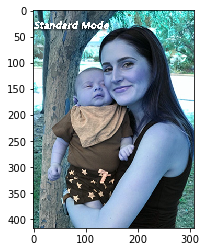

In [13]:
import matplotlib.pyplot as plt

plt.imshow(capture)
plt.show()

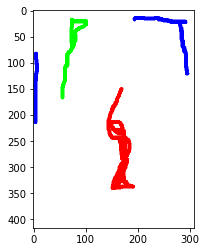

In [12]:
import matplotlib.pyplot as plt

plt.imshow(scribble)

plt.show()

TypeError: where() takes at least 1 argument (0 given)

In [15]:
laplacian = compute_laplacian(image,np.ones(image.shape))

In [16]:
print(laplacian)

  (0, 0)	0.8891292058287518
  (0, 1)	-0.11055071968392262
  (0, 2)	-0.11055071968392262
  (0, 235)	-0.1118116003950967
  (0, 236)	-0.11055071968392262
  (0, 237)	-0.11055071968392262
  (0, 470)	-0.1118116003950967
  (0, 471)	-0.1118116003950967
  (0, 472)	-0.11149152590777113
  (1, 0)	-0.11055071968392263
  (1, 1)	0.8856087780579005
  (1, 2)	-0.11439122194209944
  (1, 235)	-0.10701097257237568
  (1, 236)	-0.11439122194209944
  (1, 237)	-0.11439122194209944
  (1, 470)	-0.10701097257237568
  (1, 471)	-0.10701097257237568
  (1, 472)	-0.1108514748305525
  (2, 0)	-0.11055071968392263
  (2, 1)	-0.11439122194209944
  (2, 2)	0.8856087780579005
  (2, 235)	-0.10701097257237568
  (2, 236)	-0.11439122194209944
  (2, 237)	-0.11439122194209944
  (2, 470)	-0.10701097257237568
  :	:
  (44412, 43944)	-0.11392258010579631
  (44412, 44177)	-0.11008875875635289
  (44412, 44178)	-0.11392258010579631
  (44412, 44179)	-0.10932199447118414
  (44412, 44412)	0.8945118268782593
  (44412, 44413)	-0.11162228728849

In [17]:

scribble[np.where(scribble < 127 )] = 0
scribble[np.where(scribble >= 127 )] = 255

output = closed_form_matting_with_scribbles(capture/255, scribble/255, levels = 5)

(417, 308, 3)
(417, 308, 3)
(417, 308, 3)
(128436, 128436)
(128436, 3)


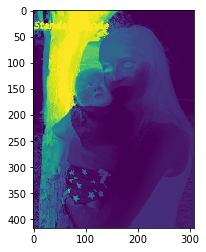

In [20]:

plt.imshow(output[:,:,1])
plt.show()

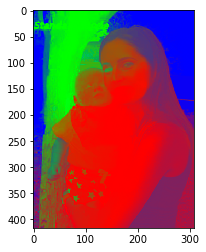

In [21]:
import matplotlib.pyplot as plt

plt.imshow(output)
plt.show()